# Spectral FPM Simulation and Reconstruction Code

Neerja Aggarwal

Sep 20th, 2023

Now let's have our object be spectrally varying.  For this, first let's assume that we have a resolution target that has the same spectrum across pixels.  Later, we can section this image using watershed or some other method so that the cross bars have different spectrum.  

## Import and Setup

In [1]:
# load relevant libraries
# activate pytorch conda environment on fuoco

%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import image
import math
import os
from IPython import display # for refreshing plotting
# plt.style.use('dark_background')

/home/neerja/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set up to use the gpu
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
use_gpu = True
gpu = 1
if use_gpu:
    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
    torch.cuda.set_device(gpu)
    device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device('cpu') # uncomment this line to use cpu
torch.cuda.empty_cache()  #empty any variables in cache to free up space
print(device)



cuda:1


CHANGE experiment parameters here:

In [3]:
mag = 4 # 4x 
pix_size_camera = 4 #  micron"
pix_size_object =pix_size_camera/mag # micron  
wv_start = 400e-3 # micron
wv_end = 800e-3 # micron
wv_step = 50e-3 # micron
wv_range = np.arange(wv_start,wv_end, wv_step)
Nw = len(wv_range)
na_obj = 0.1 # low na objective 
print(wv_range)

[0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75]


# Create helper functions

In [4]:
# start with an image in the object plane
# let's load a high resolution res target and just upsample for now?  we'll just do a mini version with limited angles. 
path = '../../DATA/SpectralFPMData/usafrestarget.jpeg'
im = torch.from_numpy(image.imread(path))[:,:,0] # pick out the first channel

def preprocessObject(im):
    (Ny,Nx) = im.shape
    # make image square
    if Ny<Nx:
        im = im[:,1:Ny]
    elif Nx<Ny:
            im = im[1:Nx,:]
    # make even dimensions
    if Ny % 2 != 0:
        im = im[:-1,:]
    if Nx % 2 != 0:
        im = im[:,:-1]

    # normalize to max value is 1
    im = im/torch.amax(im)
    return im
def makeSpectralObject(im,spectrum):
    obj = torch.unsqueeze(im,0)
    obj = obj*spectrum
    return obj

im = preprocessObject(im)
(Ny,Nx) = im.shape
Npixel = Ny


In [5]:
# make into spectral object
spectrum = torch.ones([Nw,1,1])  # create a spectrum vector with dimension (Nw, 1,1)
spectral_im = im.unsqueeze(0)*spectrum  # elementwise multiply with the sample after expanding dim0 to be wavelength

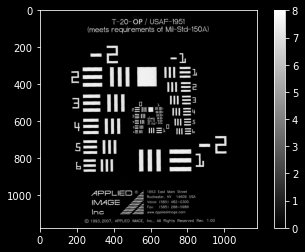

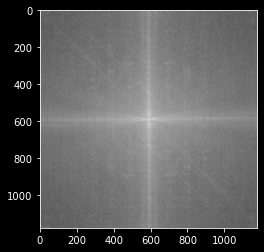

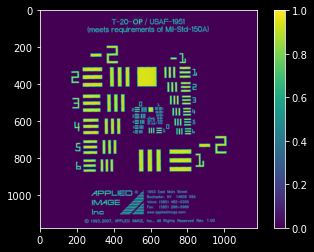

In [6]:
# look at image
sim_xy = torch.sum(spectral_im, dim=0)
plt.imshow(sim_xy,'gray')
plt.colorbar()

pup_obj = torch.fft.fftshift(torch.fft.fft2(sim_xy))
plt.figure()
plt.imshow(torch.log10(torch.abs(pup_obj)),'gray')


# look at single channel
plt.figure()
sim_0 = spectral_im[0,:,:]
plt.imshow(sim_0)
plt.colorbar()


Text(0.5, 1.0, 'Channel -1')

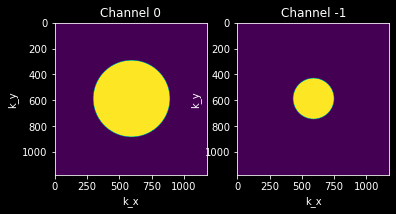

In [7]:
# make pupil mask
def createPupilStop(na_obj, wv, pix_size_object, Npixel):
    fPupilEdge = na_obj/wv # edge of pupipl is NA/wavelength
    fMax = 1/(2*pix_size_object)
    df = 1/(Npixel*pix_size_object)
    fvec = np.arange(-fMax,fMax,df)
    fxc,fyc = np.meshgrid(fvec,fvec)
    # caclulate radius of f coordinates
    frc = np.sqrt(fxc**2+fyc**2)
    pupil = np.zeros_like(frc) 
    pupil[frc<fPupilEdge] = 1 # make everything inside fPupilEdge transmit 100%
    return torch.Tensor(pupil)

pupilstack = torch.zeros([Nw,Ny,Nx])
for k in np.arange(Nw):
    wv = wv_range[k]
    pupilstack[k,:,:]  = createPupilStop(na_obj,wv,pix_size_object, Npixel)

plt.subplot(1,2,1)
plt.imshow(pupilstack[0,:,:])
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.title('Channel 0')
# plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(pupilstack[-1,:,:])
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.title('Channel -1')
# plt.colorbar()

Text(0.5, 1.0, 'Chan -1')

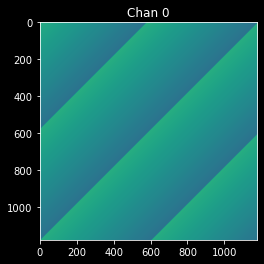

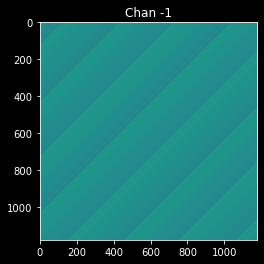

In [8]:
# create xy grid for object space (used for illumination field)
def createXYgrid(pix_size_object,Nx,Ny):
    xvec = np.arange(-pix_size_object*Nx/2,pix_size_object*Nx/2,pix_size_object)
    yvec = np.arange(-pix_size_object*Ny/2,pix_size_object*Ny/2,pix_size_object)
    xygrid = torch.Tensor(np.array(np.meshgrid(xvec,yvec)))
    return xygrid

# create the illumination field given angle of planewave
def createIllumField(xygrid, illum_angle, wv):
    rady = illum_angle[0]
    radx = illum_angle[1]
    k0 = 2*math.pi/wv
    ky = k0*math.sin(rady)
    kx = k0*math.sin(radx)
    field = torch.exp(1j*kx*xygrid[1] + 1j*ky*xygrid[0])
    return field

# look at an example illumination field
illum_angle = (.1,.1)  # y,x  # unit is in radians
xygrid = createXYgrid(pix_size_object,Nx,Ny)


# create stack of illum field
illumstack = torch.zeros([Nw,Ny,Nx],dtype = torch.complex64)  # use complex dtype
for k in np.arange(Nw):  # iterate over wavelengths
    wv = wv_range[k]
    illumstack[k,:,:] = createIllumField(xygrid,illum_angle,wv)

field_0 = illumstack[0,:,:]
plt.figure()
plt.imshow(torch.angle(field_0))
plt.title('Chan 0')


field_0 = illumstack[-1,:,:]
plt.figure()
plt.imshow(torch.angle(field_0))
plt.title('Chan -1')


Text(0.5, 1.0, 'Ground Truth')

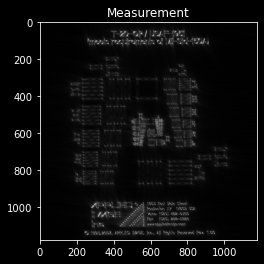

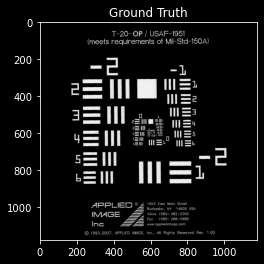

In [9]:
# compute the measurement given an object and incident wave field and pupil stop
def forwardSFPM(objstack, pupilstack, illumstack, Nw):
    # multiply by the sample
    for k in torch.arange(Nw):
        obj = objstack[k]
        pupil = pupilstack[k]
        field = illumstack[k]
        obj_field = field*obj
        # take the fourier transform and center in pupil plane
        pup_obj = torch.fft.fftshift(torch.fft.fft2(obj_field))*pupil
        # multiply object's FFT with the pupil stop and take ifft to get measurement
        if k==0:
            y = torch.abs(torch.fft.ifft2(torch.fft.fftshift(pup_obj)))
        else:
            y = y+torch.abs(torch.fft.ifft2(torch.fft.fftshift(pup_obj)))
        # subsample according to pixel size on camera?
    return (y, pup_obj)

# look at an example measurement
(y, pup_obj) = forwardSFPM(spectral_im,pupilstack, illumstack, Nw)
plt.imshow(torch.abs(y),'gray')
plt.title('Measurement')
plt.figure()
plt.imshow(im,'gray')
plt.title('Ground Truth')


## Simulate lots of forward measurements


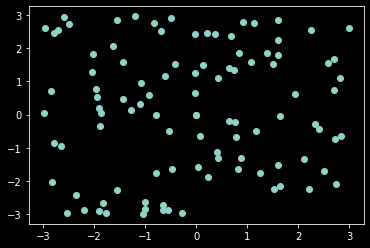

In [10]:
# create list of illumination angles (leds) to turn on one at a time
def createlist_led(num_leds,minval,maxval):
    list_leds = np.random.uniform(low = minval, high = maxval, size = (num_leds,2))
    # append a (0,0) bf led
    list_leds = np.append(list_leds,np.zeros([1,2]), axis = 0 )
    return list_leds
list_leds = createlist_led(100,-3,3) 
plt.scatter(list_leds[:,1],list_leds[:,0])

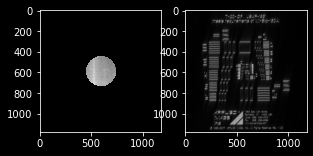

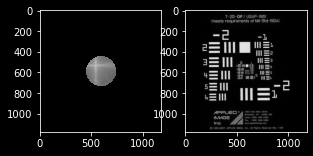

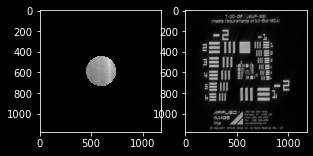

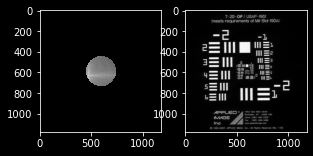

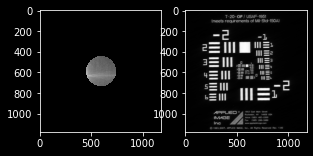

In [11]:
d = 75 # distance away led to object
# let's go up to 15 mm out (15/5 = 3)
led_spacing = 5 # roughly 5 mm apart LEDs
num_meas = len(list_leds) 
# load data
path = '../../DATA/SpectralFPMData/usafrestarget.jpeg'
obj = torch.from_numpy(image.imread(path))[:,:,0] # pick out the first channel
obj = preprocessObject(obj) # make it square and even
(Ny,Nx) = obj.shape
Npixel = Ny

# create grid and pupil
xygrid = createXYgrid(pix_size_object,Nx,Ny)
pupilstack = torch.zeros([Nw,Ny,Nx])
for k1 in np.arange(Nw):
    wv = wv_range[k1]
    pupilstack[k1,:,:]  = createPupilStop(na_obj,wv,pix_size_object, Npixel)

# create measurement stack
measstack = torch.zeros(num_meas,Ny,Nx)

#start iterating through LEDs
for k2 in np.arange(num_meas):
    # take led indices and calculate angle of incidence
    led_ind = list_leds[k2]  
    led_pos = (led_ind[0]*led_spacing,led_ind[1]*led_spacing,d) # units = millimeters, (y,x,z)
    illum_angle = (np.arctan(led_pos[0]/led_pos[2]), np.arctan(led_pos[1]/led_pos[2])) 

    # create illumination field stack 
    illumstack = torch.zeros([Nw,Ny,Nx],dtype = torch.complex64)  # use complex dtype
    for k1 in np.arange(Nw):  # iterate over wavelengths
        wv = wv_range[k]
        illumstack[k1,:,:] = createIllumField(xygrid,illum_angle,wv)
        
    # simulate the forward measurement
    (y, pup_obj) = forwardSFPM(spectral_im,pupilstack, illumstack, Nw)
    # print(k2)
    # plot some example measurements
    if k2<5:
        plt.figure(figsize=(10,10))
        plt.subplot(1,4,1)
        plt.imshow(torch.log10(torch.abs(pup_obj)),'gray')
        plt.subplot(1,4,2)
        plt.imshow(torch.abs(y),'gray')
    measstack[k2,:,:] = y


## Reconstruction

In [12]:
def computesize(a):
    return(a.element_size() * a.nelement() /1e9)

print(computesize(measstack))
print(computesize(spectral_im))
print(computesize(pupilstack))

0.560624336
0.044405888
0.044405888


In [13]:
# need regular FPM function 
# compute the measurement given an object and incident wave field and pupil stop
def forwardFPM(obj, pupil, field):
    # multiply by the sample
    obj_field = field*obj
    # take the fourier transform and center in pupil plane
    pup_obj = torch.fft.fftshift(torch.fft.fft2(obj_field))*pupil
    # multiply object's FFT with the pupil stop and take ifft to get measurement
    y = torch.abs(torch.fft.ifft2(torch.fft.fftshift(pup_obj)))
    # subsample according to pixel size on camera?
    return (y, pup_obj)

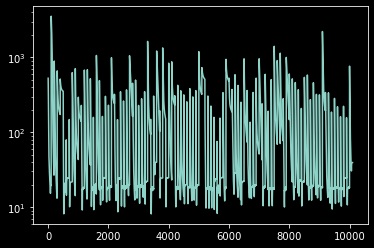

In [21]:
# obj_est = torch.zeros_like(obj,dtype = torch.float) # initializing to zeros doesn't work well. 
# obj_est = measstack[0,:,:] # initialize to first measurement instead
init_spectrum = torch.ones([Nw,1,1])  # create a spectrum vector with dimension (Nw, 1,1)
obj_est = measstack[0,:,:].unsqueeze(0).to(device)*init_spectrum.to(device)
obj_est.requires_grad = True
# regularizers
def hardthresh(x,val):
    return torch.maximum(x,torch.tensor(val))

# set hyperparameters
step_size = 1e1
num_iters = 100
num_meas = len(list_leds)
losses =[]
# move to gpu
if use_gpu == 1:
    with torch.no_grad():
        obj_est = obj_est.to(device)
        pupilstack = pupilstack.to(device)
        measstack = measstack.to(device)
        obj_est.requires_grad = True
        

    # loop through measurement
for k2 in np.arange(num_meas): 
    # loop through iterations
    for k1 in np.arange(num_iters):
        # print(k1,k2)
        # get relevant actual measurement and move to gpu
        meas = measstack[k2,:,:]
        # loop through wavelength 
        # compute illumination angle from led indices
        led_ind = list_leds[k2]   
        led_pos = (led_ind[0]*led_spacing,led_ind[1]*led_spacing,d) # units = millimeters, (x,y,z)
        illum_angle = (np.arctan(led_pos[1]/led_pos[2]), np.arctan(led_pos[0]/led_pos[2]))

        # create stack of illum field
        illumstack = torch.zeros([Nw,Ny,Nx],dtype = torch.complex64).to(device)  # use complex dtype
        for k3 in np.arange(Nw):
            wv = wv_range[k3]
            illumstack[k3,:,:] = createIllumField(xygrid,illum_angle,wv)

        # simulate the forward measurement
        (yest, pup_obj) = forwardSFPM(obj_est,pupilstack, illumstack, Nw)

        # calculate error, aka loss, and backpropagate
        error = torch.norm(yest-meas)
        losses += [error.detach().cpu()]
        error.backward()
        # print(error)

        # update the object's reconstruction estimate based on error
        with torch.no_grad(): # need to do inplace operations inside this no_grad() function to retain as leaf variables. 
            # print(torch.norm(obj_est.grad))
            obj_est = obj_est - step_size*obj_est.grad # gradient update
            obj_est = hardthresh(obj_est,0) # proximal update

        # ensure the obj_est's grad flag is set correctly for next iteration to run properly
        obj_est.requires_grad = True


        if k1 == num_iters-1:
                try:
                    print(k2,k1)
                    plt.clf() # clear plot
                    plt.semilogy(losses)
                    display.display(plt.gcf()) # update single window
                    display.clear_output(wait=True) # update single window
                    # time.sleep(1)
                except KeyboardInterrupt:
                    break

tensor(171.0401, device='cuda:1', grad_fn=<CopyBackwards>)
tensor(171.0401, device='cuda:1', grad_fn=<CopyBackwards>)
tensor(171.0401, device='cuda:1', grad_fn=<CopyBackwards>)


Text(0.5, 1.0, 'Brightfield Measurement')

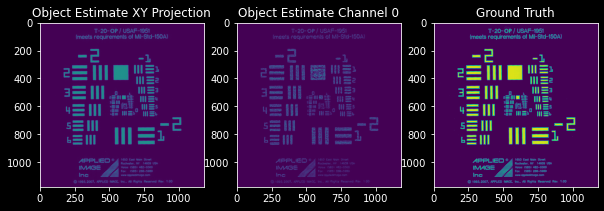

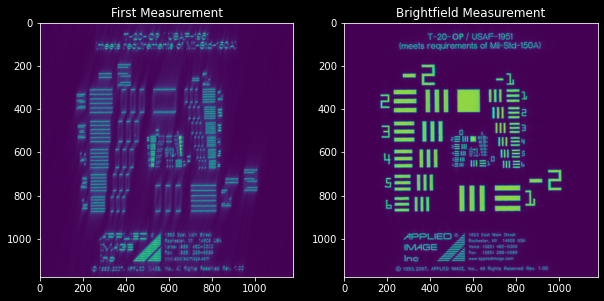

In [31]:
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
obj_est_norm = torch.sum(obj_est,dim=0)
obj_est_norm = obj_est_norm/torch.amax(obj_est_norm)
plt.imshow(obj_est_norm.detach().cpu().numpy())
plt.title('Object Estimate XY Projection')
print(torch.norm(obj_est_norm))
# plt.colorbar()
# plt.clim([0,.9])

plt.subplot(1,3,2)
obj_est0 = obj_est[0,:,:]/torch.amax(obj_est[0,:,:])
plt.imshow(obj_est0.detach().cpu().numpy())
plt.title('Object Estimate Channel 0')
print(torch.norm(obj_est_norm))
# plt.colorbar()
# plt.clim([0,.9])

plt.subplot(1,3,3)
spectral_im[0,:,:] = spectral_im[0,:,:]/torch.amax(spectral_im[0,:,:])
plt.imshow(spectral_im[0,:,:].detach().cpu().numpy())
plt.title('Ground Truth')
print(torch.norm(obj_est_norm))
# plt.colorbar()
# plt.clim([0,.9])

plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.imshow(measstack[0,:,:].detach().cpu())
plt.title('First Measurement')
# plt.colorbar()
# plt.clim([0,.3])

plt.subplot(1,2,2)
plt.imshow(measstack[-1,:,:].detach().cpu())
plt.title('Brightfield Measurement')
# plt.colorbar()
# plt.clim([0,.3])

<Figure size 432x288 with 0 Axes>

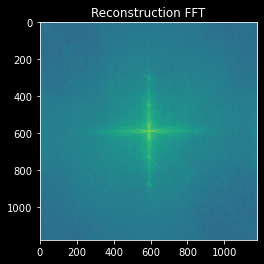

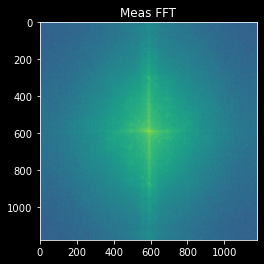

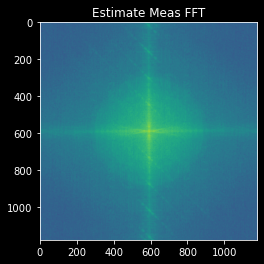

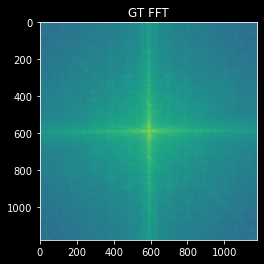

<Figure size 432x288 with 0 Axes>

In [32]:
# compute the object reconstruction's fourier transform and plot
f = torch.fft.fftshift(torch.fft.fft2(obj_est_norm)).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('Reconstruction FFT')
plt.figure()
# compute the measurement's fourier transform and plot
f = torch.fft.fftshift(torch.fft.fft2(measstack[0,:,:])).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('Meas FFT')
# compute the estimate's fourier transform and plot
plt.figure()
f = torch.fft.fftshift(torch.fft.fft2(yest)).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('Estimate Meas FFT')
# compute the object reconstruction's fourier transform and plot
plt.figure()
f = torch.fft.fftshift(torch.fft.fft2(spectral_im[0,:,:])).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('GT FFT')
plt.figure()

Text(0.5, 1.0, 'Meas FFT')

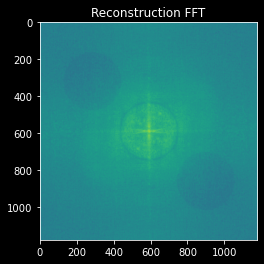

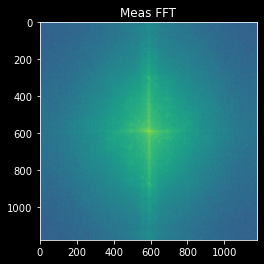

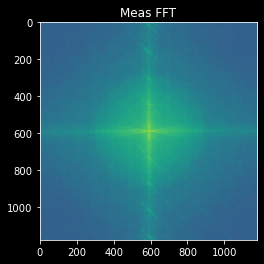

In [34]:
# compute the object reconstruction's fourier transform and plot
f = torch.fft.fftshift(torch.fft.fft2(obj_est[-1,:,:])).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('Reconstruction FFT')
plt.figure()
# compute the measurement's fourier transform and plot
f = torch.fft.fftshift(torch.fft.fft2(measstack[0,:,:])).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('Meas FFT')

# compute the estimate's fourier transform and plot
plt.figure()
f = torch.fft.fftshift(torch.fft.fft2(yest)).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('Meas FFT')